
Number of image files: 10
Number of json files: 10


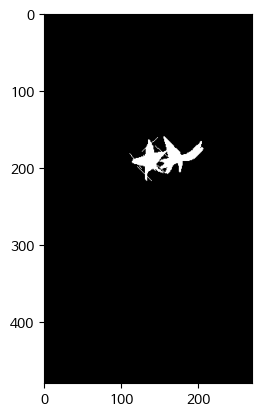

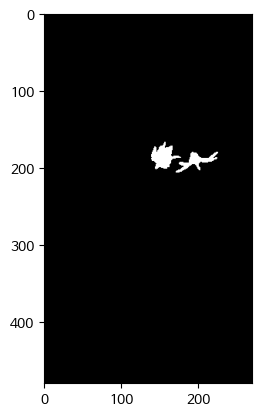

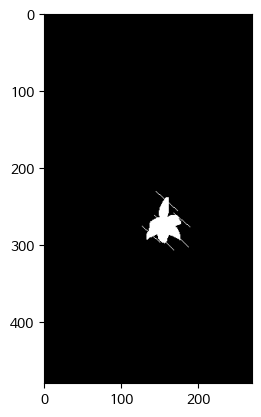

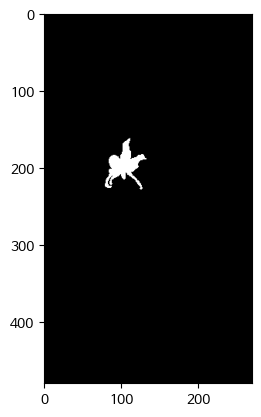

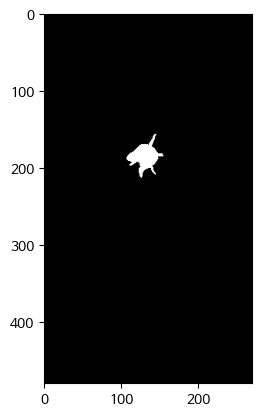

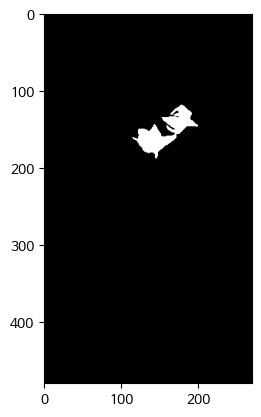

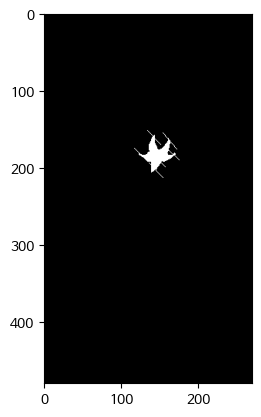

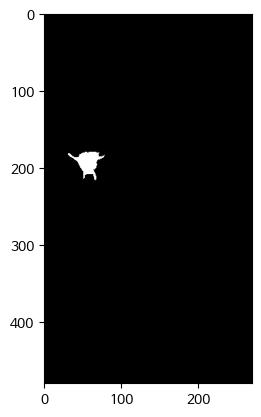

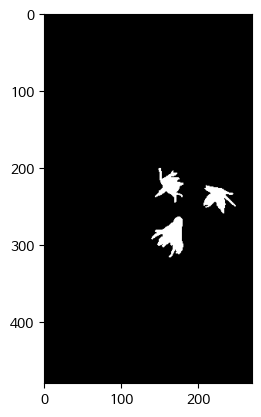

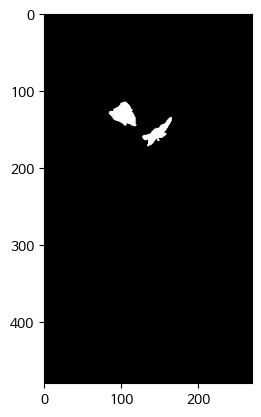

In [1]:
import cv2
import json
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout
from tensorflow.keras.models import Model
from skimage.transform import resize
from keras.layers import Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img



img_directory = 'E:\\Unet\\만개꽃_축소이미지'
json_directory = 'E:\\Unet\\만개꽃_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')][:10]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')][:10]

print(f"Number of image files: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

for image_file, json_file in zip(image_files, json_files):
    image = Image.open(image_file)
    image = np.array(image)

    if image is None:
        print(f"Cannot load image: {image_file}")
        continue

    with open(json_file, 'r') as f:
        data = json.load(f)

    original_size = (data['imageWidth'], data['imageHeight'])

    # 세그멘테이션 이미지 초기화 (모든 픽셀 값이 0인 이미지)
    segmentation = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)

    shapes = data['shapes']
    
    # points로 가져온 좌표 안쪽은 모두 1로 라벨링 하는 코드
    for shape in shapes:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(segmentation, [points], 1)
    
    # 
    new_image_path = os.path.join("E:/Unet/만개꽃/", os.path.split(image_file)[1].replace('.png', '_seg.png'))

    img_pil = Image.fromarray(segmentation * 255)  # 0과 1로 이루어진 이미지를 0과 255로 변환
    img_pil.save(new_image_path)

    # 세그멘테이션 이미지를 화면에 출력
    plt.imshow(segmentation, cmap='gray')
    plt.show()


In [2]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    drop3 = Dropout(0.5)(conv3)

    up4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop3)
    merge4 = concatenate([drop2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(drop4)
    merge5 = concatenate([drop1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    drop5 = Dropout(0.5)(conv5)

    conv6 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
    conv7 = Conv2D(1, 1, activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    return model


In [3]:
img_directory = 'E:\\Unet\\만개꽃_축소이미지'
json_directory = 'E:\\Unet\\만개꽃_축소JSON'

image_files = [os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.png')]
json_files = [os.path.join(json_directory, file.replace('.png', '.json')) for file in os.listdir(img_directory) if file.endswith('.png')]

# 학습 데이터와 테스트 데이터로 나누는 부분
image_train_files = image_files[:1100]
json_train_files = json_files[:1100]
image_test_files = image_files[1100:]
json_test_files = json_files[1100:]

# 이미지와 세그멘테이션 레이블의 크기를 조정할 크기
target_size = (480, 272)

def load_data(image_files, json_files, target_size):
    images = []
    labels = []

    for image_file, json_file in zip(image_files, json_files):
        # 이미지 로드
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)

        # 세그멘테이션 레이블 로드
        with open(json_file, 'r') as f:
            data = json.load(f)
        original_size = (data['imageWidth'], data['imageHeight'])
        segmentation = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)
        shapes = data['shapes']
        for shape in shapes:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(segmentation, [points], 1)

        # 세그멘테이션 레이블 크기 조정
        segmentation = resize(segmentation, target_size, mode='constant', preserve_range=True)

        images.append(image)
        labels.append(segmentation)

    # numpy array로 변환
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# 학습 데이터 로드
x_train, y_train = load_data(image_train_files, json_train_files, target_size)

# 학습 데이터를 평가하는 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 테스트 데이터 로드
x_test, y_test = load_data(image_test_files, json_test_files, target_size)


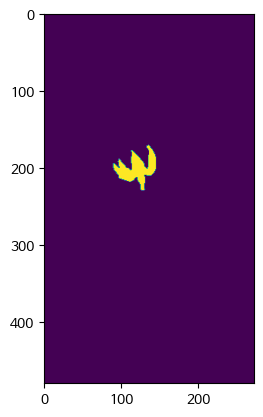

In [4]:
# 첫 번째 테스트 이미지를 가져옵니다.
test_image = y_test[10]

# 이미지의 픽셀 값 범위를 0-1 사이로 정규화합니다.
# 이미지 데이터가 0-255 사이의 값인 경우에만 필요합니다.
test_image = test_image / 255.0

# 이미지를 시각화합니다.
plt.imshow(test_image)
plt.show()

In [5]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (880, 480, 272, 3)
y_train shape: (880, 480, 272)


In [6]:
# 모델 생성
input_shape = (480, 272, 3)  # 실제 이미지의 크기
model = create_model(input_shape=input_shape)  # 실제 이미지 크기에 맞게 모델 생성

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, batch_size=32, epochs=1, validation_data=(x_val, y_val))

# 모델 저장
model.save('unet_model.h5')





28/28 [==============================] - 1735s 61s/step - loss: 0.4518 - accuracy: 0.9704 - val_loss: 0.1154 - val_accuracy: 0.9917


D:\Anaconda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# 모델 평가
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {acc}")

# 모델 예측
predictions = model.predict(x_test)

12/12 [==============================] - 60s 5s/step - loss: 0.1426 - accuracy: 0.9900
Test Loss: 0.1426418125629425, Test Accuracy: 0.9900233745574951
12/12 [==============================] - 59s 5s/step


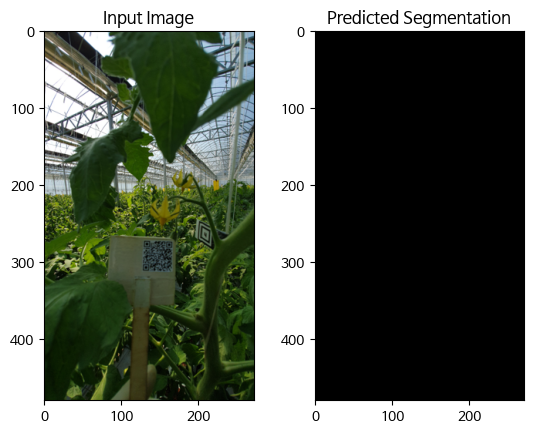

In [8]:
# 예측 결과 시각화
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_test[11] / 255.0)        # 원본 이미지
ax[0].set_title("Input Image")
ax[1].imshow(predictions[11].squeeze(), cmap='gray')  # 예측된 세그멘테이션 결과
ax[1].set_title("Predicted Segmentation")
plt.show()

In [9]:
# 결과를 확인하기 위해 작성한 코드
print(predictions[11])

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [10]:
print(predictions[10].shape)

(480, 272, 1)
